In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile
import csv
from ml.nodes import *
from ml.traces import *
from sklearn.decomposition import FastICA, PCA

In [2]:
class CDataSet(object):
    def __init__(self, ims, labs):
        self.ims = ims / 255.
        labels = np.array(labs)
        num_labels = len(set(labs))
        self.labs = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
        self.batchPtr = 0
    def shape(self):
        return self.ims.shape
    def next_batch(self, n):
        if n + self.batchPtr > len(self.labs):
            self.batchPtr = 0
        ret = self.images()[self.batchPtr:self.batchPtr+n], self.labs[self.batchPtr:self.batchPtr+n]
        self.batchPtr += n
        return ret
    def images(self):
        return self.ims
    def labels(self):
        return self.labs
    
class Cifar10(Datasets):
    def __init__(self):
        import cPickle
        def read(name):
            with open('cifar-10-batches-py/'+name) as fo:
                dict = cPickle.load(fo)
                return dict['labels'], dict['data']
        t = [ read('data_batch_%d' % (i+1)) for i in range(5)]
        trainLabels = []
        trainData = []
        for l, d in t:
            trainLabels.extend(l)
            trainData.append(d)
        trainData = np.vstack(trainData)
        self.train      = CDataSet(trainData[:-5000], trainLabels[:-5000])
        self.validation = CDataSet(trainData[-5000:], trainLabels[-5000:])
        v = read('test_batch')
        self.test       = CDataSet(v[1], v[0])
        super(Cifar10, self).__init__('Cifar10')
      
ds = Cifar10()
ds.info()

                                 Cifar10:        0     N:-1 C:3072 
Dataset: Cifar10
  shape: N:-1 C:3072 
  labels: 10
  test:       (10000, 3072)
  validation: (5000, 3072)
  train:      (45000, 3072)


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [4]:
x = ds.x
y_ = ds.y_

In [5]:
class Conv2dI(Conv2d):
    def __init__(self, inp, size, padding='VALID'):
        self.size = size
        self.ncIn = inp.dims()['C']
        
        outChannels = size*size*self.ncIn
        
        W = np.zeros((size, size, self.ncIn, outChannels))
        for h in range(size):
            for w in range(size):
                for c in range(self.ncIn):
                    k = ((h*size) + w) * self.ncIn + c 
                    W[h, w, c, k] = 1
        super(Conv2dI, self).__init__(inp, size, outChannels, padding=padding, w=W)
    

In [6]:
d = Reshape(ds, 'C', 'CHW', (3, 32, 32))
x_im = Transpose(d, 'NHWC')
c = Conv2dI(x_im, 5)
s = Reshape(c, 'C', 'YXC', (5, 5, 3))

                                 Reshape:        0     N:-1 C:3 H:32 W:32 
                               Transpose:        0     N:-1 H:32 W:32 C:3 
                                 Conv2dI:     5625     N:-1 H:28 W:28 C:75 
                                 Reshape:        0     N:-1 H:28 W:28 Y:5 X:5 C:3 


In [7]:
sess.run(tf.global_variables_initializer())

In [19]:
n = 10
batch = ds.train.next_batch(n*n)
vals, v = sess.run((s.out(), x_im.out()), feed_dict={x: batch[0], y_: batch[1]})

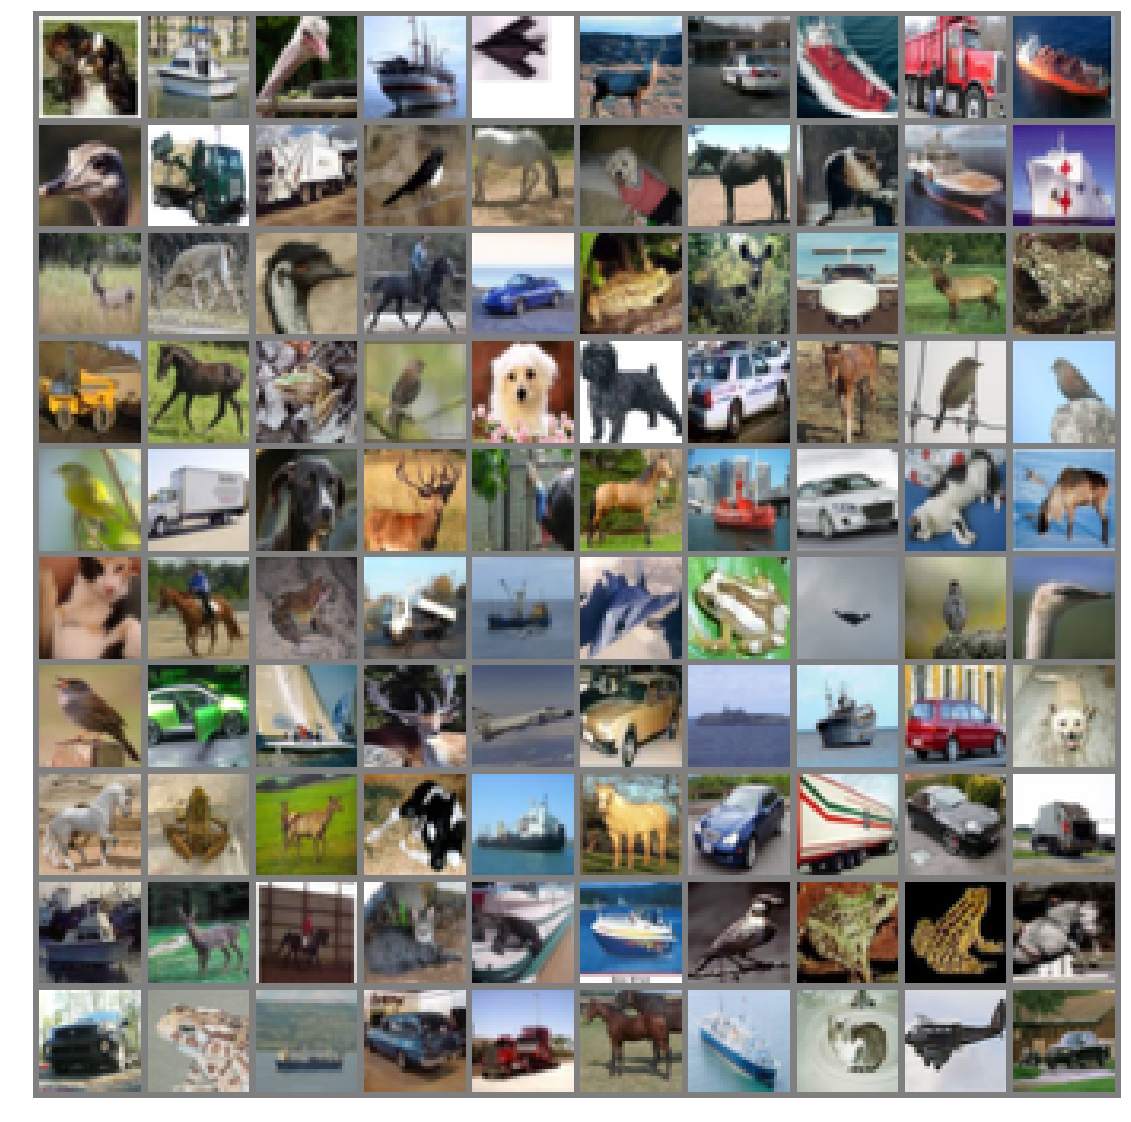

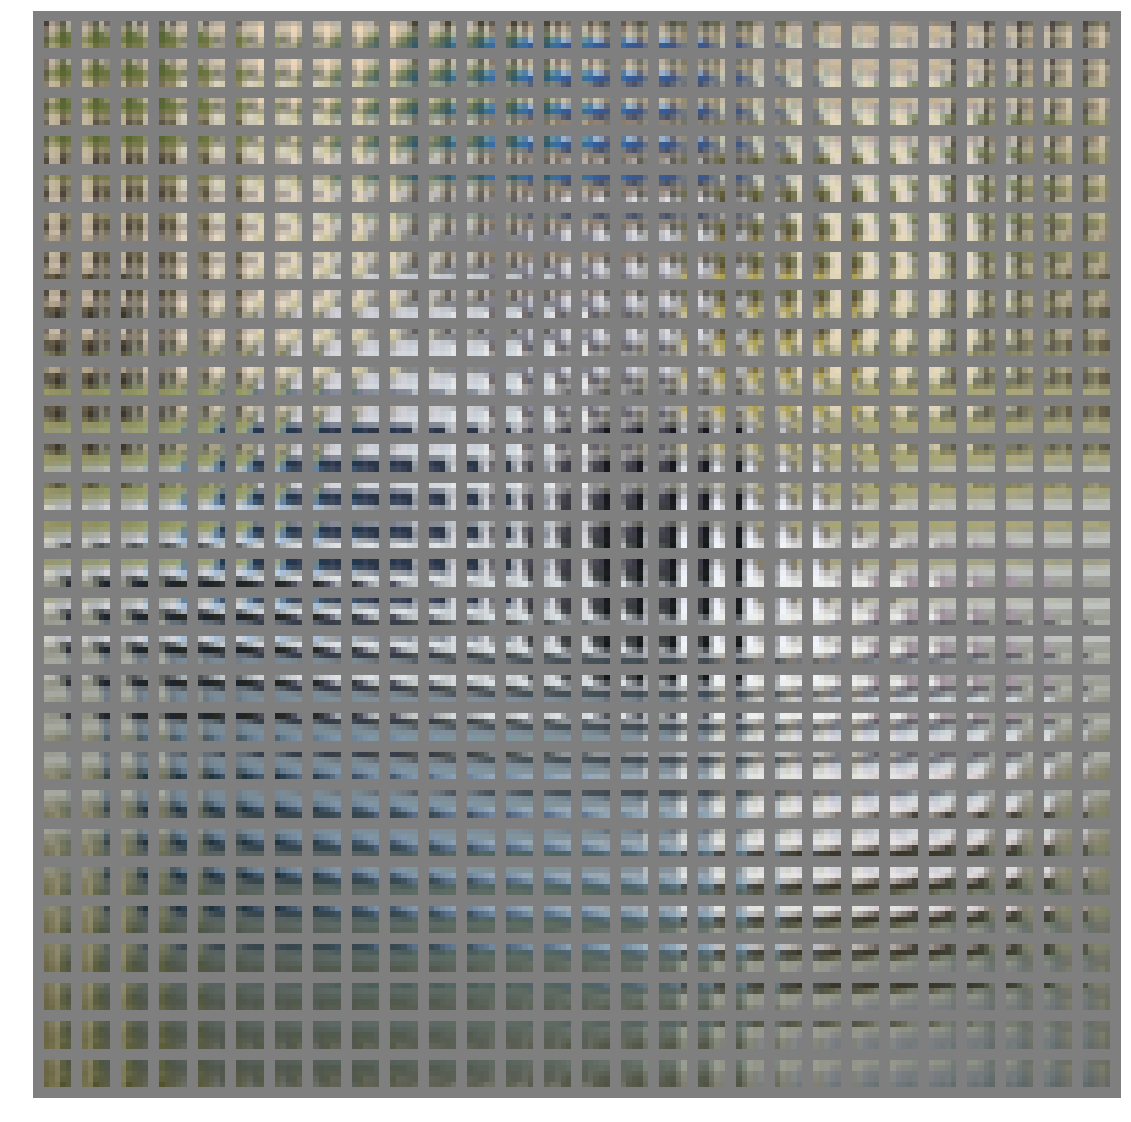

In [20]:
def show(v, node):
    fmt = node.format()
    dims = node.dims()
    if True: # fmt == 'NHWYXC':
        n, h, w, x, y, c = v.shape
        plt.figure(figsize=(20, 20))
        for imInd in range(n):
            border = 2
            sx = x+border
            sy = y+border
            szX = border + w * sx
            szY = border + h * sy
            canvas = np.ones((szY, szX, c)) # canvas is h, w
            canvas = canvas * .5
            for _w in range(w):
                for _h in range(h):
                     canvas[border+_h*sy: border+_h*sy+y, 
                            border+_w*sx: border+_w*sx+x, 
                            :] = v[imInd, _h, _w, :, :, : ]
            if c == 1:
                canvas = canvas.reshape(canvas.shape[:-1])
            s = plt.subplot(n, 1, imInd+1)
            p = plt.imshow(canvas, interpolation='none')
            p.set_cmap('gray')
            s.axis('off')
        plt.show()
        
v = v.reshape((1, n, n, 32, 32, 3))
show(v, s)
vv = vals[1:2, :, :, :, :, :]
show(vv, s)